In [1]:
%matplotlib inline
import psycopg2
import numpy as np
from pandas.io.sql import read_sql

In [8]:
pgconn = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
df = read_sql("""
 SELECT week, stddev(data), avg(data), min(data) as mines, max(data) as maxes, 
 max(case when ntile = 5 then data else -999 end) as n5,
 max(case when ntile = 95 then data else -999 end) as n95 from
 
 (select extract(week from valid) as week, tmpc as data, 
 ntile(100) OVER (PARTITION by extract(week from valid) order by tmpc ASC) from 
 raob_profile p JOIN raob_flights f on (f.fid = p.fid)
 WHERE extract(hour from valid at time zone 'UTC') = 00 and 
 f.station in ('KOAX', 'KOVN', 'KOMA') and p.pressure = 850 and tmpc is not null) as foo
 
 GROUP by week ORDER by week ASC
""", pgconn, index_col=None)


In [5]:
odf = read_sql("""
 select extract(doy from valid) as doy, tmpc from 
 raob_profile_2016 p JOIN raob_flights f on (f.fid = p.fid)
 WHERE extract(hour from valid at time zone 'UTC') = 0 and 
 f.station in ('KOAX', 'KOVN', 'KOMA') and p.pressure = 850 and tmpc is not null 
 ORDER by valid ASC
""", pgconn, index_col=None)


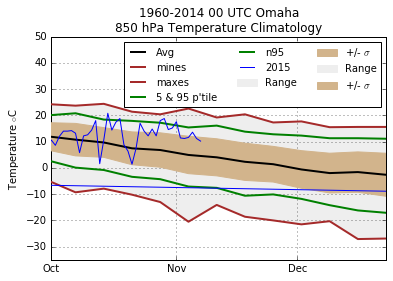

In [10]:
def fill_between(x, y1, y2=0, ax=None, **kwargs):
    """Plot filled region between `y1` and `y2`.

    This function works exactly the same as matplotlib's fill_between, except
    that it also plots a proxy artist (specifically, a rectangle of 0 size)
    so that it can be added it appears on a legend.
    """
    ax = ax if ax is not None else plt.gca()
    ax.fill_between(x, y1, y2, **kwargs)
    p = plt.Rectangle((0, 0), 0, 0, **kwargs)
    ax.add_patch(p)
    return p

import matplotlib.pyplot as plt

(fig, ax) = plt.subplots(1, 1)

fill_between(df['week'] * 7, df['mines'], df['maxes'], color='#EEEEEE', zorder=1, label='Range')
#ax.fill_between(week * 7, avg - (stddev *2.), avg + (stddev * 2.), color='lightblue', zorder=2)
fill_between(df['week'] * 7, df['avg'] - (df['stddev'] * 1.), df['avg'] + (df['stddev'] * 1.),
             color='tan', zorder=4, label="+/- $\sigma$")
ax.plot(df['week'] * 7, df['avg'], lw=2, color='k', zorder=4, label='Avg')
ax.plot(df['week'] * 7, df['mines'], lw=2, color='brown', zorder=4)
ax.plot(df['week'] * 7, df['maxes'], lw=2, color='brown', zorder=4)
ax.plot(df['week'] * 7, df['n5'], lw=2, color='g', zorder=4, label="5 & 95 p'tile")
ax.plot(df['week'] * 7, df['n95'], lw=2, color='g', zorder=4)
ax.plot(odf['doy'], odf['tmpc'], zorder=5, label='2015')
ax.set_ylim(-35,50)
ax.set_xticks( (1,32,60,91,121,152,182,213,244,274,305,335) )
ax.set_xticklabels( ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec') )
ax.set_xlim(274,(df['week'].max() - 2.) * 7)
ax.set_title("1960-2014 00 UTC Omaha\n850 hPa Temperature Climatology")
ax.set_ylabel("Temperature $\circ$C")

ax.legend(ncol=3, fontsize=10)
ax.grid(True, zorder=9)


In [16]:
fig.savefig('151204.png', dpi=100)